In [62]:
import pandas as pd

df = pd.read_csv('clean_data.csv')

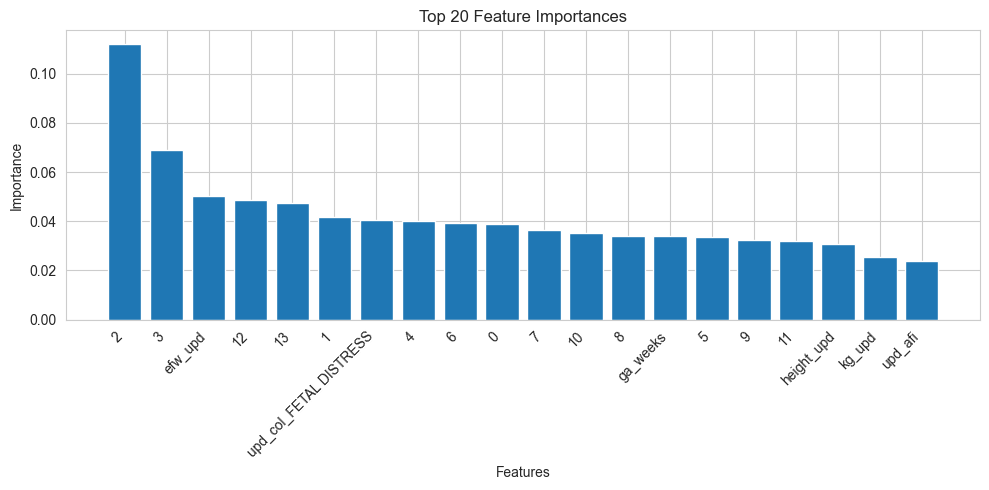

In [72]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming best_random, feature_names, and X_train are already defined
best_random = rf_random.best_estimator_
feature_names = tr_features_df.columns.tolist()
# Get feature importances
importances = best_random.feature_importances_

# Sort the feature importances in descending order and get the indices
indices = np.argsort(importances)[::-1]

# Get the feature names, sorted by importance
names = [feature_names[i] for i in indices]

# Number of features to display
num_features = 20

# Limit the data to the top 'num_features' features
sorted_importances = importances[indices[:num_features]]
sorted_names = [names[i] for i in range(num_features)]

# Create the plot
plt.figure(figsize=(10, 5))
plt.title("Top 20 Feature Importances")
plt.bar(range(num_features), sorted_importances)
plt.xticks(range(num_features), sorted_names, rotation=45, ha='right')  # Rotate labels for better readability

# Add labels and a title
plt.xlabel('Features')
plt.ylabel('Importance')

plt.tight_layout()  # Adjust subplot parameters to give the plot more room
plt.show()

Processing emilyalsentzer/Bio_ClinicalBERT...
Fitting 3 folds for each of 10 candidates, totalling 30 fits


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Processing bert-base-uncased...
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Processing dmis-lab/biobert-v1.1...
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Processing bionlp/bluebert_pubmed_mimic_uncased_L-12_H-768_A-12...
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Processing microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext...
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Fitting 3 folds for each of 10 candidates, totalling 30 fits


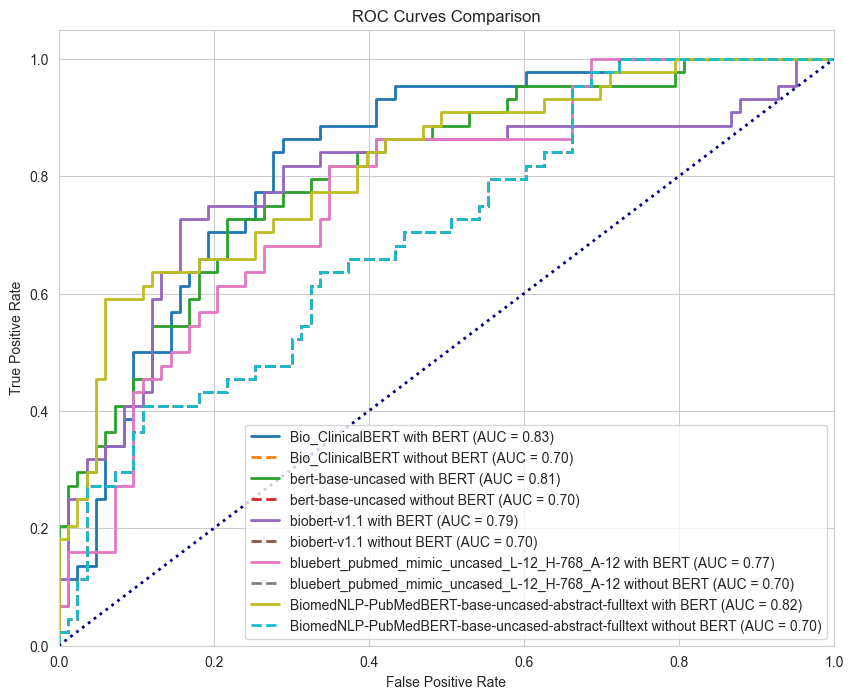

In [150]:
data_cleaned = df.copy(deep=True)


import numpy as np
import pandas as pd
import re
import string
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.decomposition import PCA
from transformers import AutoTokenizer, AutoModel
import torch

# Function to preprocess text
def preprocess_text(text):
    text = text.lower()
    text = re.sub(f'[{re.escape(string.punctuation)}]', '', text)
    return text

# Function to generate grid for RF
def get_random_grid():
    """
    Generate a dictionary with parameters names (`str`) as keys and distributions
    or lists of parameters to try.
    """
    # Number of trees in random forest
    n_estimators = [int(x) for x in np.linspace(start=100, stop=500, num=5)]
    # Number of features to consider at every split
    max_features = ['log2', 'sqrt']
    # Maximum number of levels in tree
    max_depth = [int(x) for x in np.linspace(5, 11, num=7)]
    max_depth.append(None)  # Also consider the scenario of not limiting the depth
    # Minimum number of samples required to split a node
    min_samples_split = [2, 5, 10]
    # Minimum number of samples required at each leaf node
    min_samples_leaf = [1, 2, 4]
    # Method of selecting samples for training each tree
    bootstrap = [True, False]

    # Create the random grid
    random_grid = {
        'n_estimators': n_estimators,
        'max_features': max_features,
        'max_depth': max_depth,
        'min_samples_split': min_samples_split,
        'min_samples_leaf': min_samples_leaf,
        'bootstrap': bootstrap
    }
    return random_grid


# Function to create BERT embeddings
def create_bert_embeddings(model, tokenizer, texts):
    inputs = tokenizer(texts, return_tensors="pt", padding=True, truncation=True, max_length=128)
    with torch.no_grad():
        outputs = model(**inputs)
    embeddings = outputs.last_hidden_state[:, 0, :].squeeze().detach().cpu().numpy()
    return embeddings

# Function to perform randomized search and return the best model
def perform_random_search(X, y):
    # Hyperparameter space
    random_grid = get_random_grid()
    # Random search
    rf = RandomForestClassifier(random_state=42)
    rf_random = RandomizedSearchCV(estimator=rf, param_distributions=random_grid, n_iter=10, cv=3, verbose=2, random_state=42, n_jobs=-1)
    rf_random.fit(X, y)
    return rf_random.best_estimator_

# Function to plot ROC curves
def plot_roc_curves(models, test_features, y_test, model_names):
    plt.figure(figsize=(10, 8))
    for i, (model, name) in enumerate(zip(models, model_names)):
        # Predict probabilities
        y_pred_proba = model.predict_proba(test_features[i])[:, 1]
        # Compute ROC curve and AUC
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        roc_auc = roc_auc_score(y_test, y_pred_proba)
        # Plot
        plt.plot(fpr, tpr, lw=2, label=f'{name} (AUC = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves Comparison')
    plt.legend(loc="lower right")
    plt.show()


# Preprocess the text data and split the dataset
data_cleaned['preprocessed_text'] = data_cleaned['diagnosis'].apply(preprocess_text)
X = data_cleaned.drop(columns=['delivery_mode_NVD'])  # Assuming 'delivery_mode_NVD' is your target
y = data_cleaned['delivery_mode_NVD']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Extract and preprocess numerical features
numerical_features = X_train.drop(columns=['diagnosis', 'preprocessed_text', 'Unnamed: 0', 'patient_id','prvs_lscs','fetus_type_TWIN','fetus_type_THREE'])  # Adjust as necessary
numerical_features_test = X_test.drop(columns=['diagnosis', 'preprocessed_text', 'Unnamed: 0', 'patient_id','prvs_lscs','fetus_type_TWIN','fetus_type_THREE'])  # Adjust as necessary


# Preprocess the text data and split the dataset
data_cleaned['preprocessed_text'] = data_cleaned['diagnosis'].apply(preprocess_text)
X = data_cleaned.drop(columns=['delivery_mode_NVD','diagnosis'])
y = data_cleaned['delivery_mode_NVD']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Extract and preprocess numerical features
numerical_features = X_train.drop(columns=['preprocessed_text', 'Unnamed: 0', 'patient_id'])  # Adjust as necessary
numerical_features_test = X_test.drop(columns=['preprocessed_text', 'Unnamed: 0', 'patient_id'])  # Adjust as necessary

# Define BERT models to compare
bert_models = [
    "emilyalsentzer/Bio_ClinicalBERT",
    "bert-base-uncased",
    "dmis-lab/biobert-v1.1",
    "bionlp/bluebert_pubmed_mimic_uncased_L-12_H-768_A-12",
    "microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext"
]

# Initialize storage for models and features
best_models_with_bert = []
best_models_without_bert = []
test_features_with_bert = []
test_features_without_bert = []

for bert_model in bert_models:
    print(f"Processing {bert_model}...")
    tokenizer = AutoTokenizer.from_pretrained(bert_model)
    model = AutoModel.from_pretrained(bert_model)

    # Generate BERT embeddings
    train_embeddings = np.vstack([create_bert_embeddings(model, tokenizer, batch.to_numpy().tolist()) for batch in np.array_split(X_train['preprocessed_text'], 10)])
    test_embeddings = np.vstack([create_bert_embeddings(model, tokenizer, batch.to_numpy().tolist()) for batch in np.array_split(X_test['preprocessed_text'], 10)])

    # Optional: Dimensionality reduction
    pca = PCA(n_components=0.75, svd_solver='full')
    train_embeddings_reduced = pca.fit_transform(train_embeddings)
    test_embeddings_reduced = pca.transform(test_embeddings)

    # Combine embeddings with numerical features for the "with BERT" model
    train_combined_with_bert = np.hstack([train_embeddings_reduced, numerical_features.values])
    test_combined_with_bert = np.hstack([test_embeddings_reduced, numerical_features_test.values])

    # Train and evaluate models with BERT embeddings
    best_model_with_bert = perform_random_search(train_combined_with_bert, y_train)
    best_models_with_bert.append(best_model_with_bert)
    test_features_with_bert.append(test_combined_with_bert)

    # Train and evaluate models without BERT embeddings (only numerical features)
    best_model_without_bert = perform_random_search(numerical_features.values, y_train)
    best_models_without_bert.append(best_model_without_bert)
    test_features_without_bert.append(numerical_features_test.values)

# Function to plot ROC curves, modified to handle both model types
def plot_comparison_roc_curves(models_with_bert, models_without_bert, test_features_with_bert, test_features_without_bert, y_test, model_names):
    plt.figure(figsize=(10, 8))

    for i, name in enumerate(model_names):
        # With BERT
        y_pred_proba_with_bert = models_with_bert[i].predict_proba(test_features_with_bert[i])[:, 1]
        fpr_with_bert, tpr_with_bert, _ = roc_curve(y_test, y_pred_proba_with_bert)
        roc_auc_with_bert = roc_auc_score(y_test, y_pred_proba_with_bert)

        # Without BERT
        y_pred_proba_without_bert = models_without_bert[i].predict_proba(test_features_without_bert[i])[:, 1]
        fpr_without_bert, tpr_without_bert, _ = roc_curve(y_test, y_pred_proba_without_bert)
        roc_auc_without_bert = roc_auc_score(y_test, y_pred_proba_without_bert)

        # Plot
        plt.plot(fpr_with_bert, tpr_with_bert, label=f'{name} with BERT (AUC = {roc_auc_with_bert:.2f})', lw=2)
        plt.plot(fpr_without_bert, tpr_without_bert, label=f'{name} without BERT (AUC = {roc_auc_without_bert:.2f})', lw=2, linestyle='--')

    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle=':')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves Comparison')
    plt.legend(loc="lower right")
    plt.show()

# Simplify model names for the legend
model_names = [model.split("/")[-1] for model in bert_models]

# Plot ROC curves comparison
plot_comparison_roc_curves(best_models_with_bert, best_models_without_bert, test_features_with_bert, test_features_without_bert, y_test, model_names)

In [154]:
y_train.value_counts(), y_test.value_counts()

(0    297
 1    207
 Name: delivery_mode_NVD, dtype: int64,
 0    83
 1    44
 Name: delivery_mode_NVD, dtype: int64)